<h2 align=center> Facial Expression Recognition</h2>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile 
with ZipFile("/content/drive/MyDrive/ferdata/data.zip") as zf:
    zf.extractall("/content/data")

In [6]:
train_dir = "/content/data/data/train/"
test_dir = "/content/data/data/test/"

3995 angry images
4097 fear images
7214 happy images
4830 sad images
436 disgust images
3171 surprise images
4965 neutral images

In [7]:
for expression in os.listdir(train_dir):
    print(str(len(os.listdir(train_dir + expression))) + " " + expression + " images")

4097 fear images
436 disgust images
4830 sad images
3995 angry images
4965 neutral images
7215 happy images
3171 surprise images


### Generate Training and Validation Batches

In [8]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(train_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(test_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Create CNN Model

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Train and Evaluate Model

In [ ]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_best.h5", monitor='val_accuracy',
                             save_weights_only=False, mode='max', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.8093 - accuracy: 0.3060
Epoch 1: saving model to model_best.h5
448/448 [==============================] - 42s 65ms/step - loss: 1.8093 - accuracy: 0.3060 - val_loss: 1.5632 - val_accuracy: 0.3927 - lr: 5.0000e-04
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4902 - accuracy: 0.4292
Epoch 2: saving model to model_best.h5
448/448 [==============================] - 28s 63ms/step - loss: 1.4902 - accuracy: 0.4292 - val_loss: 1.3692 - val_accuracy: 0.4703 - lr: 5.0000e-04
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3297 - accuracy: 0.4878
Epoch 3: saving model to model_best.h5
448/448 [==============================] - 29s 64ms/step - loss: 1.3297 - accuracy: 0.4878 - val_loss: 1.3102 - val_accuracy: 0.4840 - lr: 5.0000e-04
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2497 - accuracy: 0.5232
Epoch 4: saving model to model_best.h5
448/448 [=

Text(0.5, 1.0, 'loss')

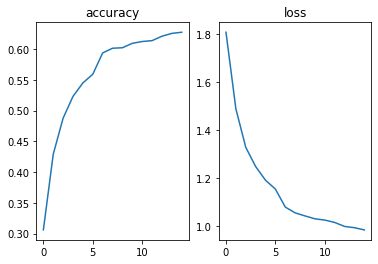

In [ ]:
plt.subplot(1,2,1)
plt.plot(list(range(15)), history.history['accuracy'])
plt.title("accuracy")
plt.subplot(1,2,2)
plt.plot(list(range(15)), history.history['loss'])
plt.title("loss")

# save model

In [ ]:
model.save("/content/drive/My Drive/Facial Exp/model_acc64.h5")

## load and test

In [3]:
model = load_model("/content/drive/MyDrive/Facial Exp/model_acc64.h5")

In [20]:
# classes = {i:j for j,i in train_generator.class_indices.items()}

In [21]:
# import pickle
# with open("/content/drive/MyDrive/Facial Exp/classes.pkl", "wb") as clp:
#   pickle.dump(classes, clp)

In [4]:
import pickle
with open("/content/drive/MyDrive/Facial Exp/classes.pkl", "rb") as cpkl:
  classes = pickle.load(cpkl)

##upload and test

In [5]:
from google.colab import files
def uat():
  name = list(files.upload().keys())[0]
  img = cv2.resize(io.imread(f"/content/{name}", as_gray=True), dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
  plt.imshow(img, cmap='gray')
  cls = model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0))
  print("class: ", classes[cls.argmax()])

Saving aaaaaaaayn.jpg to aaaaaaaayn.jpg
class:  sad


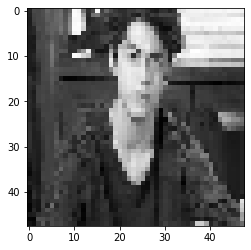

In [6]:
uat()

Saving aandyan.jpg to aandyan.jpg
class:  sad


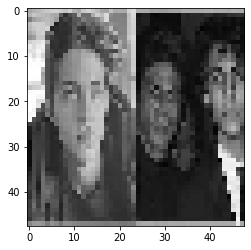

In [7]:
uat()